# EECS 498-007/598-005 Assignment 4-2: RNN, LSTM, and Attention for Image Captioning

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX

# Image Captioning with RNNs
In this exercise you will implement a vanilla recurrent neural networks and use them it to train a model that can generate novel captions for images.

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
# uncomment and run this if you are using google colab

# from google.colab import drive
# drive.mount('/content/drive')

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['eecs598', 'network_visualization.py', 'style_transfer.py',  'network_visualization.ipynb', 'a4_helper.py', 'pytorch_autograd_and_nn.py', 'pytorch_autograd_and_nn.ipynb', 'style_transfer.ipynb', 'rnn_lstm_attention_captioning.ipynb',  'rnn_lstm_attention_captioning.py']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'

# uncomment below two lines if using google colab with Google drive
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# comment below line if using google colab with Google drive
GOOGLE_DRIVE_PATH = './'

print(os.listdir(GOOGLE_DRIVE_PATH))

['datasets', 'network_visualization.py', 'style_transfer.py', 'rnn_lstm_attention_captioning.py', 'a4_helper.py', 'eecs598', 'pytorch_autograd_and_nn.py', 'style_transfer.ipynb', 'rnn_lstm_attention_captioning.ipynb', 'network_visualization.ipynb', '__pycache__', 'pytorch_autograd_and_nn.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from rnn_lstm_attention_captioning.py!
```

as well as the last edit time for the file `rnn_lstm_attention_captioning.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset() 

from rnn_lstm_attention_captioning import *
from a4_helper import *
hello()

py_path = os.path.join(GOOGLE_DRIVE_PATH, 'rnn_lstm_attention_captioning.py')
py_edit_time = time.ctime(os.path.getmtime(py_path))
print('rnn_lstm_attention_captioning.py last edited on %s' % py_edit_time)

Hello from rnn_lstm_attention_captioning.py!
rnn_lstm_attention_captioning.py last edited on Sat Jul 31 05:22:13 2021


### Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F

from eecs598.utils import reset_seed, tensor_to_image, decode_captions, attention_visualizer
from eecs598.grad import rel_error, compute_numeric_gradient
import matplotlib.pyplot as plt
import time

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go!


# Microsoft COCO
For this exercise we will use the 2014 release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

We have preprocessed the data for you already and saved them into a serialized data file. It contains 10,000 image-caption pairs for training and 500 for testing. The images have been downsampled to 112x112 for computation efficiency and captions are tokenized and numericalized, clamped to 15 words. You can download the file named `coco.pt` (378MB) with the link below and run some useful stats.

You will later use MobileNet v2 to extract features for the images. A few notes on the caption preprocessing:

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is saved in an entry named `vocab` (both `idx_to_token` and `token_to_idx`), and we use the function `decode_captions` from `a4_helper.py` to convert tensors of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

In [7]:
# Download and load serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (112x112)
# "val_images" - resized validation images (112x112)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"

if os.path.isfile('./datasets/coco.pt'):
  print('COCO data exist')
else:
  print('downloading COCO dataset')
  !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt -P ./datasets/

# load COCO data from coco.pt, loaf_COCO is implemented in a4_helper.py
data_dict = load_COCO(path = './datasets/coco.pt')

num_train = data_dict['train_images'].size(0)
num_val = data_dict['val_images'].size(0)

# declare variables for special tokens
NULL_index = data_dict['vocab']['token_to_idx']['<NULL>']
START_index = data_dict['vocab']['token_to_idx']['<START>']
END_index = data_dict['vocab']['token_to_idx']['<END>']
UNK_index = data_dict['vocab']['token_to_idx']['<UNK>']


COCO data exist
train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])

Train images shape:  torch.Size([10000, 3, 112, 112])
Train caption tokens shape:  torch.Size([10000, 17])
Validation images shape:  torch.Size([500, 3, 112, 112])
Validation caption tokens shape:  torch.Size([500, 17])
total number of caption tokens:  864
mappings (list) from index to caption token:  ['<NULL>', '<START>', '<END>', '<UNK>', 'a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'man', 'to', 'sitting', 'two', 'an', 'standing', 'people', 'are', 'at', 'next', 'white', 'woman', 'table', 'that', 'street', 'holding', 'some', 'person', 'down', 'large', 'top', 'group', 'tennis', 'field', 'it', 'plate', '

## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function.

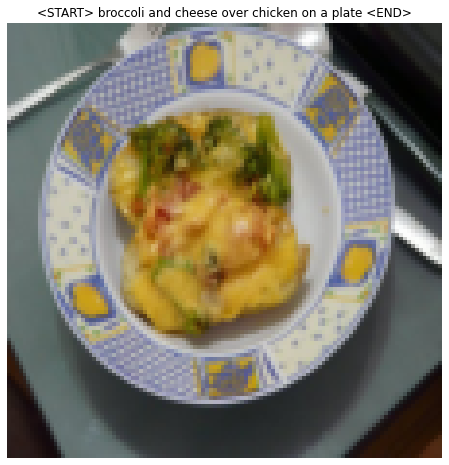

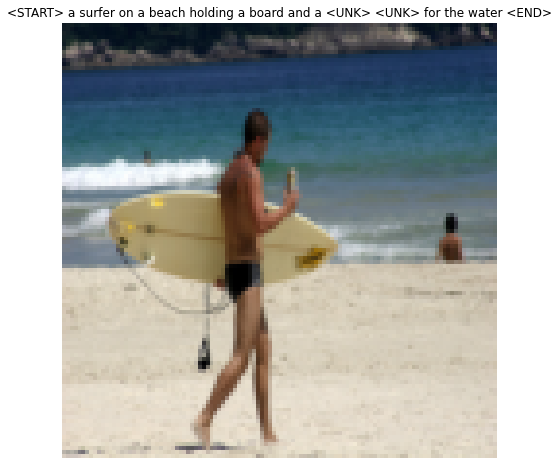

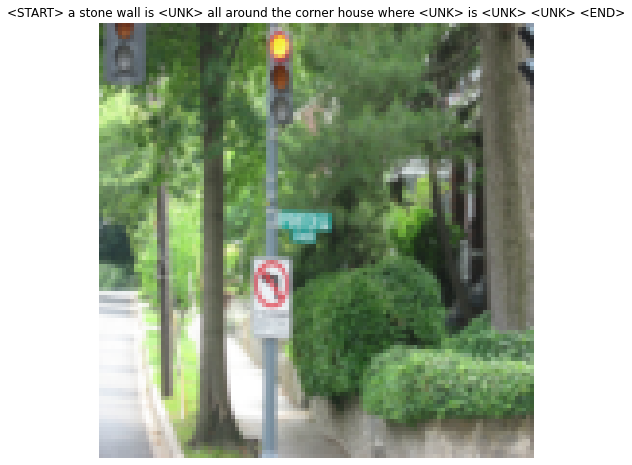

In [8]:
# Sample a minibatch and show the reshaped 112x112 images and captions
batch_size = 3

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  plt.title(caption_str)
  plt.show()

# Recurrent Neural Networks
As discussed in lecture, we will use Recurrent Neural Network (RNN) language models for image captioning. We will cover the vanilla RNN model first and later LSTM and attention-based language models.

## Vanilla RNN: step forward
First implement the `rnn_step_forward` for a single timestep of a vanilla recurrent neural network. Run the following to check your implementation. You should see errors on the order of `1e-8` or less.

In [9]:
N, D, H = 3, 10, 4

x = torch.linspace(-0.4, 0.7, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.2, 0.5, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.1, 0.9, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.3, 0.7, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.2, 0.4, steps=H, **to_double_cuda)

# YOUR_TURN: Impelement rnn_step_forward 
next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = torch.tensor([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  2.3200594408551194e-09


## Vanilla RNN: step backward
Then implement the `rnn_step_backward` for a single timestep of a vanilla recurrent neural network. Run the following to numerically gradient check your implementation. You should see errors on the order of `1e-8` or less.

In [10]:
reset_seed(0)
N, D, H = 4, 5, 6
x = torch.randn(N, D, **to_double_cuda)
h = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = torch.randn(*out.shape, **to_double_cuda)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dnext_h)
dprev_h_num = compute_numeric_gradient(fh, h, dnext_h)
dWx_num = compute_numeric_gradient(fWx, Wx, dnext_h)
dWh_num = compute_numeric_gradient(fWh, Wh, dnext_h)
db_num = compute_numeric_gradient(fb, b, dnext_h)

# YOUR_TURN: Impelement rnn_step_backward
dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  3.530076340711781e-10
dprev_h error:  1.023333169118312e-09
dWx error:  1.635986317441122e-10
dWh error:  3.862381098421698e-10
db error:  1.2566134268642678e-10


## Vanilla RNN: forward
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that processes an entire sequence of data. First implement `rnn_forward` by making calls to the `rnn_step_forward` function that you defined earlier.

Run the following to check your implementation. You should see errors on the order of `1e-6` or less.



In [11]:
N, T, D, H = 2, 3, 4, 5

x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
h0 = torch.linspace(-0.3, 0.1, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.2, 0.4, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.4, 0.1, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.7, 0.1, steps=H, **to_double_cuda)

# YOUR_TURN: Impelement rnn_forward
h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = torch.tensor([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]], **to_double_cuda)
print('h error: ', rel_error(expected_h, h))

h error:  4.242275290213816e-09


## Vanilla RNN: backward
Implement the `rnn_backward` for a vanilla RNN. This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that you defined earlier. You should see errors on the order of `1e-6` or less.


In [12]:
reset_seed(0)

N, D, T, H = 2, 3, 10, 5

x = torch.randn(N, T, D, **to_double_cuda)
h0 = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

# YOUR_TURN: Impelement rnn_backward
dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
dh0_num = compute_numeric_gradient(fh0, h0, dout)
dWx_num = compute_numeric_gradient(fWx, Wx, dout)
dWh_num = compute_numeric_gradient(fWh, Wh, dout)
db_num = compute_numeric_gradient(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  5.815642230504831e-10
dh0 error:  7.125196140592365e-10
dWx error:  8.020741839108524e-10
dWh error:  1.1608144889788916e-09
db error:  1.2083739927736994e-09


## Vanilla RNN: backward with autograd
Now it's time to introduce the lifesaver PyTorch Automatic Differantiation package - `torch.autograd`!

`torch.autograd` provides classes and functions implementing **automatic differentiation** of arbitrary scalar valued functions. It requires minimal changes to the existing code - if you pass tensors with `requires_grad=True` to the forward function you wrote earlier, you can just call `.backward(gradient=grad)` on the output to compute gradients on the input and weights.

Now we can compare the manual backward pass with the autograd backward pass. **Read through the following.**  You should get a relative error less than `1e-12`.

In [13]:
reset_seed(0)

N, D, T, H = 2, 3, 10, 5

# set requires_grad=True
x = torch.randn(N, T, D, **to_double_cuda, requires_grad=True)
h0 = torch.randn(N, H, **to_double_cuda, requires_grad=True)
Wx = torch.randn(D, H, **to_double_cuda, requires_grad=True)
Wh = torch.randn(H, H, **to_double_cuda, requires_grad=True)
b = torch.randn(H, **to_double_cuda, requires_grad=True)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

# manual backward
with torch.no_grad():
  dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

# backward with autograd
out.backward(dout) # the magic happens here!
dx_auto, dh0_auto, dWx_auto, dWh_auto, db_auto = \
  x.grad, h0.grad, Wx.grad, Wh.grad, b.grad

print('dx error: ', rel_error(dx_auto, dx))
print('dh0 error: ', rel_error(dh0_auto, dh0))
print('dWx error: ', rel_error(dWx_auto, dWx))
print('dWh error: ', rel_error(dWh_auto, dWh))
print('db error: ', rel_error(db_auto, db))

dx error:  1.940674388170321e-16
dh0 error:  2.2836060460754644e-17
dWx error:  3.1057613445099113e-17
dWh error:  8.260278707379766e-17
db error:  1.3268315583600828e-16


## RNN Module
We can now wrap the vanilla RNN we wrote into an `nn.Module`. `nn.Module` is a base class for all neural network modules, more details regarding its attributes, functions, and methods could be found [here](https://pytorch.org/docs/stable/nn.html?highlight=module#torch.nn.Module).

Here we want to set up a module for RNN, where function `__init__` sets up weight and biases, and function `forward` call the `rnn_forward` function from before.

**We have written this part in `RNN` for you but you are highly recommended to go through the code as you will write `modules` on your own later.**

All the implementation will be with `autograd` and `nn.Module` going forward. 

# RNN for image captioning
You will implement a few necessary tools and layers in order to build an image captioning model (class `CaptioningRNN`).

## Image Feature Extraction
Here, we use [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) for image feature extraction. For vanilla RNN and LSTM, we use the pooled CNN feature activation. For Attention LSTM, we use the CNN feature activation map after the last convolution layer. Checkout the `FeatureExtractor` method in `rnn_lstm_attention_captioning.py` to see the initialization of the model.

Now, let's see what's inside MobileNet v2. Assume we have a 3x112x112 image input. We pass argument `pooling=True` to the model so the CNN activation is spatially-pooled from `1280x4x4` to `1280`.

In [14]:
model = FeatureExtractor(pooling=True, verbose=True, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 56, 56]             864
       BatchNorm2d-2           [-1, 32, 56, 56]              64
             ReLU6-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]             288
       BatchNorm2d-5           [-1, 32, 56, 56]              64
             ReLU6-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]             512
       BatchNorm2d-8           [-1, 16, 56, 56]              32
  InvertedResidual-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           1,536
      BatchNorm2d-11           [-1, 96, 56, 56]             192
            ReLU6-12           [-1, 96, 56, 56]               0
           Conv2d-13           [-1, 96, 28, 28]             864
      BatchNorm2d-14           [-1, 96,

## Word embedding
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

Implement the module `WordEmbedding.forward` to convert words (represented by integers) into vectors. Run the following to check your implementation. You should see an error on the order of `1e-7` or less. 


In [15]:
N, T, V, D = 2, 4, 5, 3

x = torch.tensor([[0, 3, 1, 2], [2, 1, 0, 3]], **to_long_cuda)
W = torch.linspace(0, 1, steps=V*D, **to_double_cuda).reshape(V, D)

# YOUR_TURN: Impelement WordEmbedding
model_emb = WordEmbedding(V, D, **to_double_cuda)
model_emb.W_embed.data.copy_(W)
out = model_emb(x)
expected_out = torch.tensor([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]], **to_double_cuda)

print('out error: ', rel_error(expected_out, out))

out error:  2.727272753724473e-09


## (Temporal) Affine layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. This could be easily done with the [`nn.Linear`](https://pytorch.org/docs/master/nn.html#torch.nn.Linear) module. It can also work as a regular affine layer, like the one you have implemented from previous assignments. Run the following examples to see how it works. You will intensively use `nn.Linear` later.

In [16]:
reset_seed(0)

N, T, D, M = 2, 3, 4, 3

w = torch.linspace(-0.2, 0.4, steps=D*M, **to_double_cuda).reshape(D, M).permute(1, 0)
b = torch.linspace(-0.4, 0.1, steps=M, **to_double_cuda)

temporal_affine = nn.Linear(D, M).to(**to_double_cuda)
temporal_affine.weight.data.copy_(w)
temporal_affine.bias.data.copy_(b)

# For regular affine layer
x = torch.linspace(-0.1, 0.3, steps=N*D, **to_double_cuda).reshape(N, D)
out = temporal_affine(x)
print('affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[-0.35584416, -0.10896104,  0.13792208],
                     [-0.31428571, -0.01753247,  0.27922078]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))


# For temporal affine layer
x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
out = temporal_affine(x)
print('\ntemporal affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[[-0.39920949, -0.16533597,  0.06853755],
                             [-0.38656126, -0.13750988,  0.11154150],
                             [-0.37391304, -0.10968379,  0.15454545]],
                            [[-0.36126482, -0.08185771,  0.19754941],
                             [-0.34861660, -0.05403162,  0.24055336],
                             [-0.33596838, -0.02620553,  0.28355731]]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))

affine layer - input shape: torch.Size([2, 4]), output shape: torch.Size([2, 3])
dx error:  6.021897849884195e-09

temporal affine layer - input shape: torch.Size([2, 3, 4]), output shape: torch.Size([2, 3, 3])
dx error:  6.039603964764421e-09


## Temporal Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `ignore_index` that tells it which index in caption should be ignored when computing the loss.

Implement the `temporal_softmax_loss` and run the follwing cell to check if the implmentation is correct.

In [17]:
def check_loss(N, T, V, p):
    x = 0.001 * torch.randn(N, T, V, **to_double_cuda)
    y = torch.randint(V, size=(N, T), **to_long_cuda)
    mask = torch.rand(N, T, **to_double_cuda)
    y[mask > p] = 0
    # YOUR_TURN: Impelement temporal_softmax_loss
    print(temporal_softmax_loss(x, y, NULL_index).item())
  
check_loss(1000, 1, 10, 1.0)   # Should be about 2.00-2.11
check_loss(1000, 10, 10, 1.0)  # Should be about 20.6-21.0
check_loss(5000, 10, 10, 0.1) # Should be about 2.00-2.11

2.081579100245958
20.790085742790517
2.062650592437941


## Captioning Module
Now we are wrapping everything into the captioning module. Implement the `CaptioningRNN.__init__` function for initialization and the `CaptioningRNN.forward` for the forward pass. For now you only need to implement for the case where `cell_type='rnn'`, indicating vanialla RNNs; you will implement the `LSTM` case and `AttentionLSTM` case later.

Skip the `CaptioningRNN.sample` for now, we will come back to this later.

Run the following to check your forward pass using a small test case; you should see difference on the order of `1e-7` or less.

In [18]:
reset_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

# YOUR_TURN: Impelement CaptioningRNN
model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          ignore_index=NULL_index,
          **to_float_cuda) # use float here to be consistent with MobileNet v2


for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 150.6090393066

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  150.60903930664062
expected loss:  150.6090393066
difference:  0.0


## Image Captioning solver
Different from the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use the `torch.optim` package to train image captioning models.

We have written this part for you and you need to train the model and generate plots on the training loss.

In [19]:
def captioning_train(rnn_model, image_data, caption_data, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnn_model.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(image_data.shape[0] // batch_size)
  loss_history = []
  rnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      images, captions = image_data[j*batch_size:(j+1)*batch_size], \
                           caption_data[j*batch_size:(j+1)*batch_size]

      loss = rnn_model(images, captions)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()
  return rnn_model, loss_history

## Overfit small data
Once you have familiarized yourself with the `optim` API used above, run the following to make sure your model overfits a small sample of 50 training examples. You should see a final loss of less than `1.6` and it should be done fairly quickly.

learning rate is:  0.001
(Epoch 0 / 80) loss: 75.2581 time per epoch: 0.0s
(Epoch 1 / 80) loss: 70.5093 time per epoch: 0.0s
(Epoch 2 / 80) loss: 65.4774 time per epoch: 0.0s
(Epoch 3 / 80) loss: 60.9565 time per epoch: 0.0s
(Epoch 4 / 80) loss: 56.1431 time per epoch: 0.0s
(Epoch 5 / 80) loss: 51.6361 time per epoch: 0.0s
(Epoch 6 / 80) loss: 48.0135 time per epoch: 0.0s
(Epoch 7 / 80) loss: 45.3123 time per epoch: 0.0s
(Epoch 8 / 80) loss: 43.2344 time per epoch: 0.0s
(Epoch 9 / 80) loss: 41.6105 time per epoch: 0.0s
(Epoch 10 / 80) loss: 40.3483 time per epoch: 0.0s
(Epoch 11 / 80) loss: 39.2966 time per epoch: 0.0s
(Epoch 12 / 80) loss: 38.3471 time per epoch: 0.0s
(Epoch 13 / 80) loss: 37.4502 time per epoch: 0.0s
(Epoch 14 / 80) loss: 36.6074 time per epoch: 0.0s
(Epoch 15 / 80) loss: 35.8793 time per epoch: 0.0s
(Epoch 16 / 80) loss: 35.6995 time per epoch: 0.0s
(Epoch 17 / 80) loss: 36.3894 time per epoch: 0.0s
(Epoch 18 / 80) loss: 34.1965 time per epoch: 0.0s
(Epoch 19 / 80) 

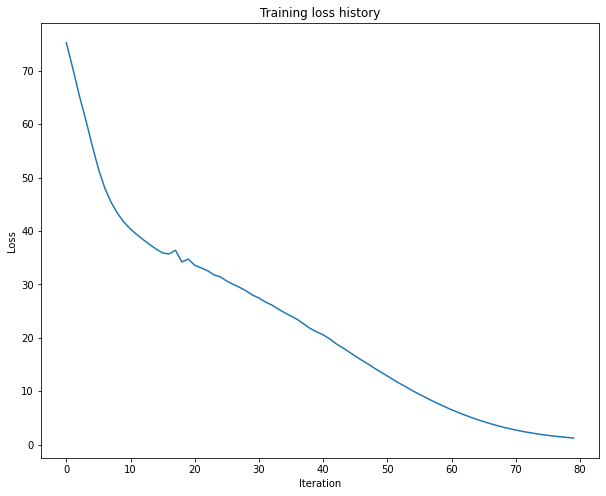

In [20]:
reset_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50
  
# create the image captioning model
model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  rnn_overfit, _ = captioning_train(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling
Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

Implement the `CaptioningRNN.sample` for test-time sampling. After doing so, run the following to train a captioning model and sample from the model on both training and validation data.

### Train the net
After you are done implementing the `CaptioningRNN.sample` method, perform the training on the entire training set. You should see a final loss less than `2.0` and each epoch should take ~6s to run.

learning rate is:  0.001
(Epoch 0 / 60) loss: 47.9724 time per epoch: 4.5s
(Epoch 1 / 60) loss: 42.2064 time per epoch: 4.5s
(Epoch 2 / 60) loss: 38.6309 time per epoch: 4.5s
(Epoch 3 / 60) loss: 36.2671 time per epoch: 4.5s
(Epoch 4 / 60) loss: 34.0328 time per epoch: 4.5s
(Epoch 5 / 60) loss: 32.1638 time per epoch: 4.5s
(Epoch 6 / 60) loss: 30.7024 time per epoch: 4.5s
(Epoch 7 / 60) loss: 28.8949 time per epoch: 4.5s
(Epoch 8 / 60) loss: 27.5098 time per epoch: 4.5s
(Epoch 9 / 60) loss: 25.9191 time per epoch: 4.5s
(Epoch 10 / 60) loss: 24.5271 time per epoch: 4.5s
(Epoch 11 / 60) loss: 23.3226 time per epoch: 4.5s
(Epoch 12 / 60) loss: 22.5171 time per epoch: 4.5s
(Epoch 13 / 60) loss: 21.0904 time per epoch: 4.5s
(Epoch 14 / 60) loss: 20.0557 time per epoch: 4.5s
(Epoch 15 / 60) loss: 18.7991 time per epoch: 4.5s
(Epoch 16 / 60) loss: 17.9996 time per epoch: 4.5s
(Epoch 17 / 60) loss: 16.9308 time per epoch: 4.5s
(Epoch 18 / 60) loss: 15.7070 time per epoch: 4.5s
(Epoch 19 / 60) 

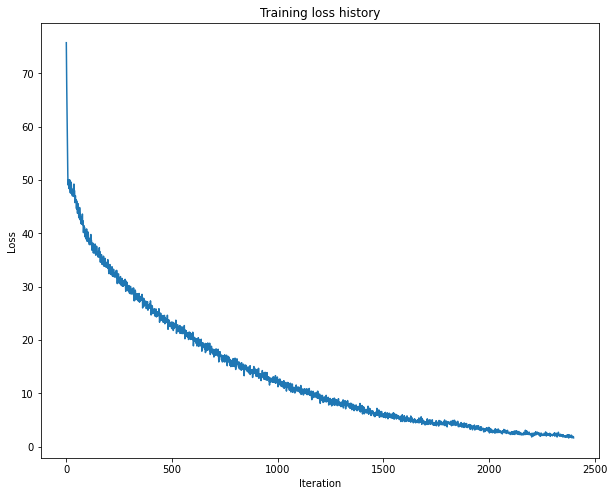

In [21]:
reset_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  rnn_model_submit, rnn_loss_submit = captioning_train(rnn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling
The samples on training data should be very good; the samples on validation data will probably make less sense.

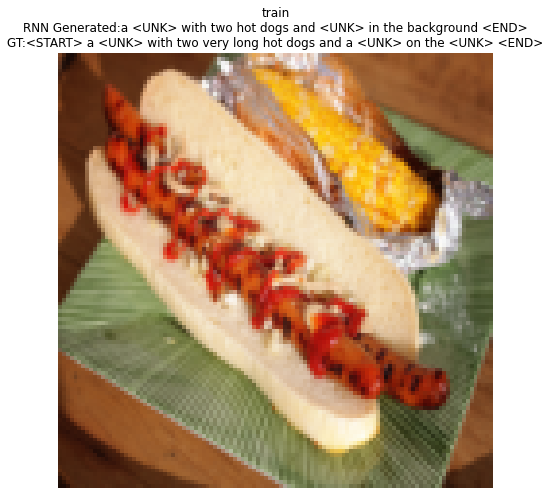

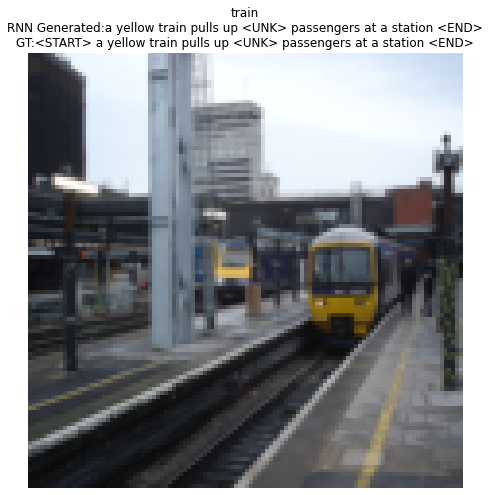

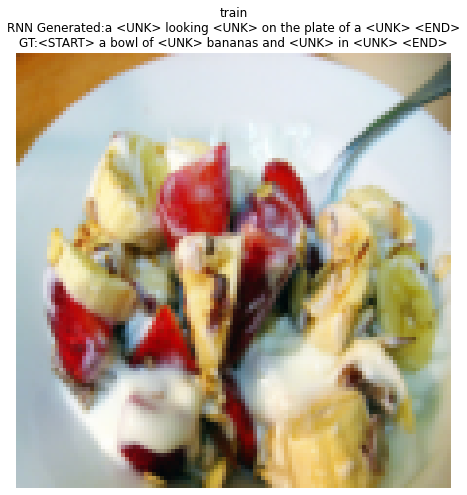

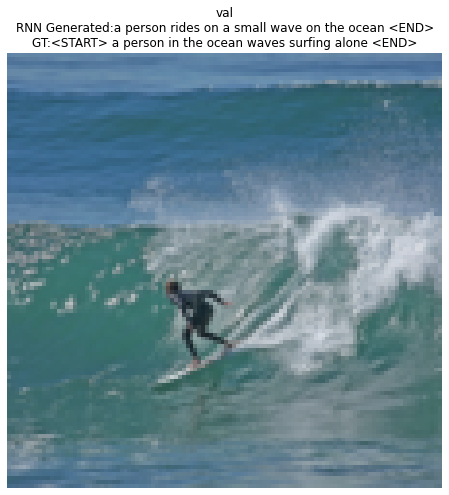

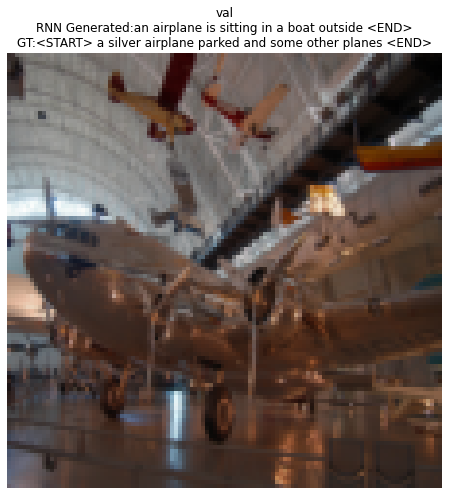

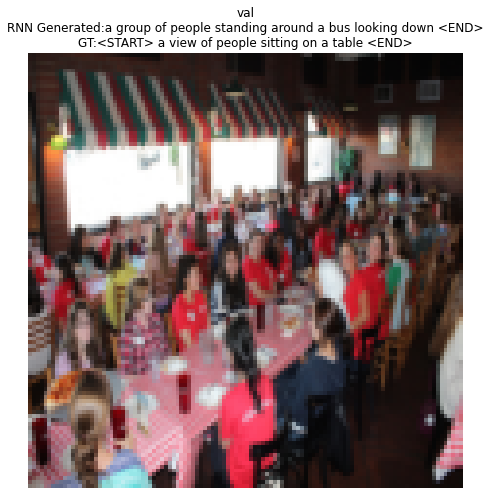

In [22]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  rnn_model.eval()
  generated_captions = rnn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nRNN Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. Next, we will implement the LSTM update rule and use it for image captioning.

# LSTM
If you read recent papers, you'll see that many people use a variant on the vanilla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

## LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Don't worry about the backward part! `autograd` will handle it.

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `1e-7` or less.

In [23]:
N, D, H = 3, 4, 5
x = torch.linspace(-0.4, 1.2, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.3, 0.7, steps=N*H, **to_double_cuda).reshape(N, H)
prev_c = torch.linspace(-0.4, 0.9, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-2.1, 1.3, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.7, 2.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.3, 0.7, steps=4*H, **to_double_cuda)

# YOUR_TURN: Impelement lstm_step_forward
next_h, next_c = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = torch.tensor([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]], **to_double_cuda)
expected_next_c = torch.tensor([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  2.606541143878583e-09
next_c error:  1.7376745523804369e-09


## LSTM: forward
Implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

Again, don't worry about the backward part! `autograd` will handle it.

When you are done, run the following to check your implementation. You should see an error on the order of `1e-7` or less.

In [24]:
N, D, H, T = 2, 5, 4, 3
x = torch.linspace(-0.4, 0.6, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
h0 = torch.linspace(-0.4, 0.8, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.2, 0.9, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.3, 0.6, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.2, 0.7, steps=4*H, **to_double_cuda)

# YOUR_TURN: Impelement lstm_forward
h = lstm_forward(x, h0, Wx, Wh, b)

expected_h = torch.tensor([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]], **to_double_cuda)

print('h error: ', rel_error(expected_h, h))

h error:  2.668523515654886e-09


## LSTM Module

We can now wrap the LSTM functions we wrote into an nn.Module. You can check the `LSTM` module in the script.

## LSTM captioning model

Now that you have implemented an LSTM, update the `CaptioningRNN.__init__` and `CaptioningRNN.forward` implementation method **ONLY** to also handle the case where `self.cell_type` is `lstm`. **This should require adding less than 5 lines of code.**

Once you have done so, run the following to check your implementation. You should see a difference on the order of `1e-7` or less.

In [25]:
reset_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

# YOUR_TURN: Impelement CaptioningRNN for lstm 
model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          ignore_index=NULL_index,
          **to_float_cuda)

for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 146.3161468505

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  146.316162109375
expected loss:  146.3161468505
difference:  5.214321112077035e-08


## Overfit small data
We have written this part for you. Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than `4` after 80 epochs and it should run fairly quickly.

learning rate is:  0.01
(Epoch 0 / 80) loss: 74.8756 time per epoch: 0.0s
(Epoch 1 / 80) loss: 70.2642 time per epoch: 0.0s
(Epoch 2 / 80) loss: 53.4651 time per epoch: 0.0s
(Epoch 3 / 80) loss: 49.1844 time per epoch: 0.0s
(Epoch 4 / 80) loss: 48.8316 time per epoch: 0.0s
(Epoch 5 / 80) loss: 47.0401 time per epoch: 0.0s
(Epoch 6 / 80) loss: 45.2403 time per epoch: 0.0s
(Epoch 7 / 80) loss: 43.4889 time per epoch: 0.0s
(Epoch 8 / 80) loss: 42.4037 time per epoch: 0.0s
(Epoch 9 / 80) loss: 40.9512 time per epoch: 0.0s
(Epoch 10 / 80) loss: 39.4983 time per epoch: 0.0s
(Epoch 11 / 80) loss: 38.0563 time per epoch: 0.0s
(Epoch 12 / 80) loss: 36.4314 time per epoch: 0.0s
(Epoch 13 / 80) loss: 34.7481 time per epoch: 0.0s
(Epoch 14 / 80) loss: 32.5479 time per epoch: 0.0s
(Epoch 15 / 80) loss: 31.2083 time per epoch: 0.0s
(Epoch 16 / 80) loss: 28.9415 time per epoch: 0.0s
(Epoch 17 / 80) loss: 27.0891 time per epoch: 0.0s
(Epoch 18 / 80) loss: 24.9372 time per epoch: 0.0s
(Epoch 19 / 80) l

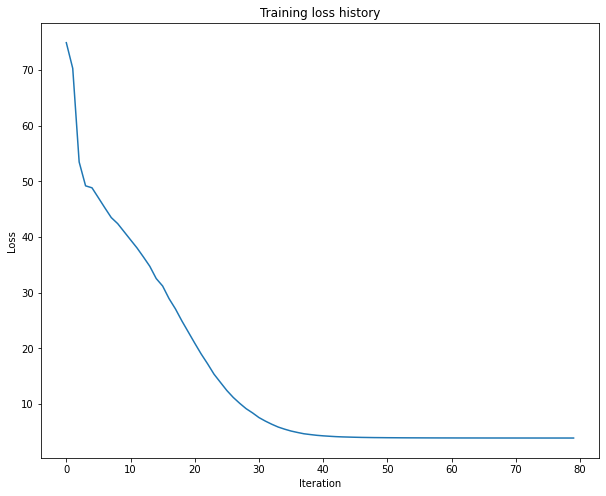

In [26]:
reset_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-2]:
  print('learning rate is: ', learning_rate)
  lstm_overfit, _ = captioning_train(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling
Modify the  `CaptioningRNN.sample` method in class to handle the case where `self.cell_type` is `lstm`. **This should take fewer than 10 lines of code.**

When you are done, run the following to train a captioning model and sample from your the model on some training and validation set samples.

### Train the net
Now, perform the training on the entire training set. You should see a final loss less than `2.8`. Each epoch should take ~7s to run.

learning rate is:  0.001
(Epoch 0 / 60) loss: 49.2967 time per epoch: 5.2s
(Epoch 1 / 60) loss: 44.2398 time per epoch: 5.2s
(Epoch 2 / 60) loss: 40.2115 time per epoch: 5.2s
(Epoch 3 / 60) loss: 38.1012 time per epoch: 5.2s
(Epoch 4 / 60) loss: 36.2543 time per epoch: 5.2s
(Epoch 5 / 60) loss: 34.5984 time per epoch: 5.2s
(Epoch 6 / 60) loss: 33.1426 time per epoch: 5.2s
(Epoch 7 / 60) loss: 31.8003 time per epoch: 5.2s
(Epoch 8 / 60) loss: 30.5522 time per epoch: 5.2s
(Epoch 9 / 60) loss: 29.4873 time per epoch: 5.2s
(Epoch 10 / 60) loss: 28.3665 time per epoch: 5.2s
(Epoch 11 / 60) loss: 27.4985 time per epoch: 5.2s
(Epoch 12 / 60) loss: 26.3519 time per epoch: 5.2s
(Epoch 13 / 60) loss: 25.3224 time per epoch: 5.2s
(Epoch 14 / 60) loss: 24.4026 time per epoch: 5.2s
(Epoch 15 / 60) loss: 23.5445 time per epoch: 5.2s
(Epoch 16 / 60) loss: 22.6008 time per epoch: 5.2s
(Epoch 17 / 60) loss: 21.7093 time per epoch: 5.2s
(Epoch 18 / 60) loss: 20.7450 time per epoch: 5.2s
(Epoch 19 / 60) 

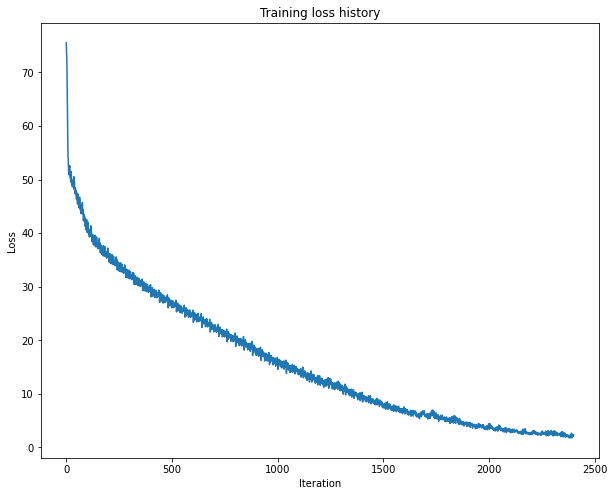

In [27]:
reset_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  lstm_model_submit, lstm_loss_submit = captioning_train(lstm_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling
As with the RNN, the samples on training data should be very good; the samples on validation data will probably make less sense.

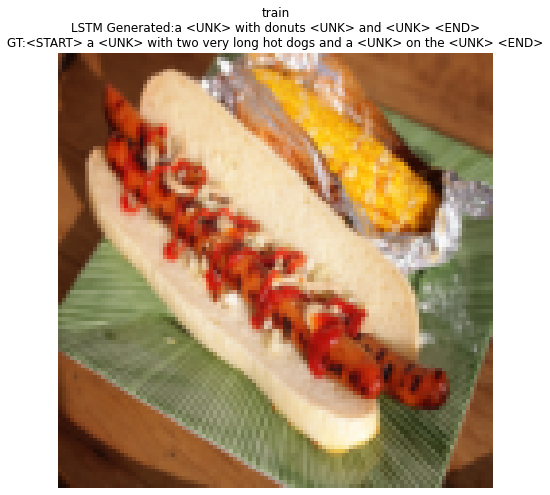

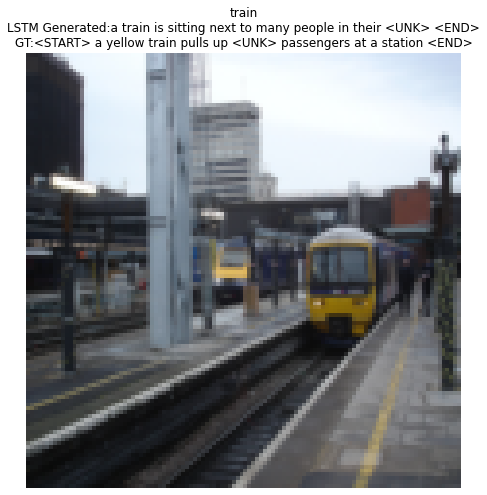

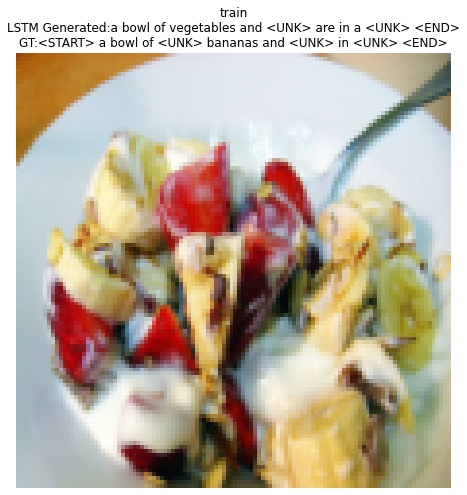

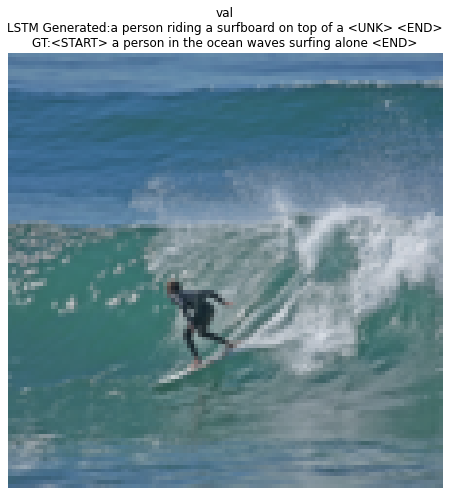

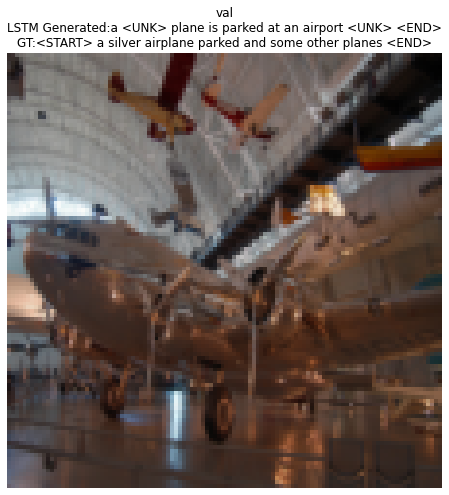

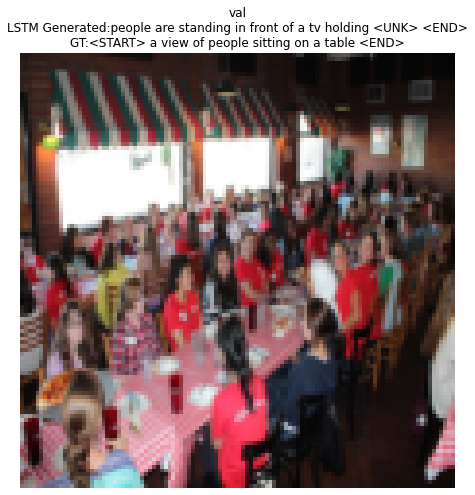

In [28]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  lstm_model.eval()
  generated_captions = lstm_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nLSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

# Attention LSTM
Attention LSTM essentially adds an attention input $x_{attn}^t\in\mathbb{R}^H$ into LSTM, along with $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$.

To get the attention input $x_{attn}^t$, here we adopt a method called `scaled dot-product attention`, as covered in the lecture. We first project the CNN feature activation from $\mathbb{R}^{1280\times4\times4}$ to $\mathbb{R}^{H\times4\times4}$ using an affine layer. Given the projected activation $A\in \mathbb{R}^{H\times4\times4}$ and the LSTM hidden state from the previous time step $h_{t-1}$, we formuate the attention weights on $A$ at time step $t$ as $M_{attn}^t=h_{t-1}A/\sqrt{H} \in \mathbb{R}^{4\times4}$.

To simplify the formuation here, we flatten the spatial dimensions of $A$ and $M_{attn}^t$ which gives $\tilde{A}\in \mathbb{R}^{H\times16}$ and $\tilde{M^t}_{attn}=h_{t-1}A\in \mathbb{R}^{16}$.
We add a **`softmax`** activation function on $\tilde{M^t}_{attn}$ so that the attention weights at each time step are normalized and sum up to one.

The attention embedding given the attention weights is then $x_{attn}^t=\tilde{A}\tilde{M^t}_{attn} \in\mathbb{R}^H$.

You will implement a batch version of the attention layer we have described here.

## Scaled dot-product attention
Implement the `dot_product_attention` function. Given the LSTM hidden state from the previous time step `prev_h` (or $h_{t-1}$) and the projected CNN feature activation `A`, compute the attention weights `attn_weights` (or $\tilde{M^t}_{attn}$ with a reshaping to $\mathbb{R}^{4\times4}$) attention embedding output `attn` (or $x_{attn}^t$) using the formulation we provided.

When you are done, run the following to check your implementation. You should see an error on the order of `1e-7` or less.

In [29]:
N, H = 2, 5
D_a = 4

prev_h = torch.linspace(-0.4, 0.6, steps=N*H, **to_double_cuda).reshape(N, H)
A = torch.linspace(-0.4, 1.8, steps=N*H*D_a*D_a, **to_double_cuda).reshape(N, H, D_a, D_a)

# YOUR_TURN: Impelement dot_product_attention
attn, attn_weights = dot_product_attention(prev_h, A)

expected_attn = torch.tensor([[-0.29784344, -0.07645979,  0.14492386,  0.36630751,  0.58769115],
        [ 0.81412643,  1.03551008,  1.25689373,  1.47827738,  1.69966103]], **to_double_cuda)
expected_attn_weights = torch.tensor([[[0.06511126, 0.06475411, 0.06439892, 0.06404568],
         [0.06369438, 0.06334500, 0.06299754, 0.06265198],
         [0.06230832, 0.06196655, 0.06162665, 0.06128861],
         [0.06095243, 0.06061809, 0.06028559, 0.05995491]],

        [[0.05717142, 0.05784357, 0.05852362, 0.05921167],
         [0.05990781, 0.06061213, 0.06132473, 0.06204571],
         [0.06277517, 0.06351320, 0.06425991, 0.06501540],
         [0.06577977, 0.06655312, 0.06733557, 0.06812722]]], **to_double_cuda)

print('attn error: ', rel_error(expected_attn, attn))
print('attn_weights error: ', rel_error(expected_attn_weights, attn_weights))

attn error:  1.4410324402829568e-09
attn_weights error:  3.5290517247691244e-08


## Attention LSTM: step forward

Modify the `lstm_step_forward` function from earlier to support the extra attention input `attn` (or $x_{attn}$) and its embedding weight matrix `Wattn` (or $W_{attn}$) in the LSTM cell. Hence, at each timestep the *activation vector* $a\in\mathbb{R}^{4H}$ in LSTM cell is formulated as:

$a=W_xx_t + W_hh_{t-1}+W_{attn}x_{attn}^t+b$.


**This should require adding less than 5 lines of code.**

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `1e-8` or less.

In [30]:
N, D, H = 3, 4, 5

x = torch.linspace(-0.4, 1.2, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.3, 0.7, steps=N*H, **to_double_cuda).reshape(N, H)
prev_c = torch.linspace(-0.4, 0.9, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-2.1, 1.3, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.7, 2.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.3, 0.7, steps=4*H, **to_double_cuda)
attn = torch.linspace(0.6, 1.8, steps=N*H, **to_double_cuda).reshape(N, H)
Wattn = torch.linspace(1.3, 4.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)

# YOUR_TURN: Impelement lstm_step_forward
next_h, next_c = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b, attn, Wattn)

expected_next_h = torch.tensor([
    [0.53704256, 0.59980774, 0.65596820, 0.70569729, 0.74932626],
    [0.78729857, 0.82010653, 0.84828362, 0.87235677, 0.89283167],
    [0.91017981, 0.92483119, 0.93717126, 0.94754073, 0.95623746]], **to_double_cuda)
expected_next_c = torch.tensor([
    [0.59999328, 0.69285041, 0.78570758, 0.87856479, 0.97142202],
    [1.06428558, 1.15714276, 1.24999992, 1.34285708, 1.43571424],
    [1.52857143, 1.62142857, 1.71428571, 1.80714286, 1.90000000]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  2.425617005126452e-09
next_c error:  1.2938551985068886e-09


## Attention LSTM: forward


Now, implement the `attention_forward` function to run an Attention LSTM forward on an entire timeseries of data. You will have to use the `dot_product_attention` function and the `lstm_step_forward` function you implemented.

Again, don't worry about the backward part! `autograd` will handle it.

When you are done, run the following to check your implementation. You should see an error on the order of `1e-8` or less.


In [31]:
N, D, H, T = 2, 5, 4, 3
D_a = 4

x = torch.linspace(-0.4, 0.6, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
A = torch.linspace(-0.4, 1.8, steps=N*H*D_a*D_a, **to_double_cuda).reshape(N, H, D_a, D_a)
Wx = torch.linspace(-0.2, 0.9, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.3, 0.6, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
Wattn = torch.linspace(1.3, 4.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.2, 0.7, steps=4*H, **to_double_cuda)

# YOUR_TURN: Impelement attention_forward
h = attention_forward(x, A, Wx, Wh, Wattn, b)

expected_h = torch.tensor([
        [[0.56141729, 0.70274849, 0.80000386, 0.86349400],
         [0.89556391, 0.92856726, 0.94950579, 0.96281018],
         [0.96792077, 0.97535465, 0.98039623, 0.98392994]],

        [[0.95065880, 0.97135490, 0.98344373, 0.99045552],
         [0.99317679, 0.99607466, 0.99774317, 0.99870293],
         [0.99907382, 0.99946784, 0.99969426, 0.99982435]]], **to_double_cuda)

print('h error: ', rel_error(expected_h, h))

h error:  2.487302938381543e-09


## Attention LSTM Module


## Attention LSTM captioning model

We can now wrap the Attention LSTM functions we wrote into an nn.Module. You can look at the `AttentionLSTM` class for detailed implementation.

Now that you have implemented an attention module, update the implementation of `CaptioningRNN.__init__` and `CaptioningRNN.forward` method to also handle the case where `self.cell_type` is `attention`. **This should require adding less than 10 lines of code.**

Once you have done so, run the following to check your implementation. You should see a difference on the order of `1e-7` or less.

In [32]:
reset_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

# YOUR_TURN: Modify CaptioningRNN for attention
model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='attention',
          ignore_index=NULL_index,
          **to_float_cuda)

for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 46.9113769531

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  46.91138458251953
expected loss:  46.9113769531
difference:  8.131709626082036e-08


## Overfit small data
We have written this part for you. Run the following to overfit an Attention LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than `9`.

learning rate is:  0.001
(Epoch 0 / 80) loss: 75.0161 time per epoch: 0.0s
(Epoch 1 / 80) loss: 69.3593 time per epoch: 0.0s
(Epoch 2 / 80) loss: 62.0421 time per epoch: 0.0s
(Epoch 3 / 80) loss: 55.0847 time per epoch: 0.0s
(Epoch 4 / 80) loss: 50.5975 time per epoch: 0.0s
(Epoch 5 / 80) loss: 47.9815 time per epoch: 0.0s
(Epoch 6 / 80) loss: 46.0970 time per epoch: 0.0s
(Epoch 7 / 80) loss: 44.6175 time per epoch: 0.0s
(Epoch 8 / 80) loss: 43.4819 time per epoch: 0.0s
(Epoch 9 / 80) loss: 42.2862 time per epoch: 0.0s
(Epoch 10 / 80) loss: 41.5222 time per epoch: 0.0s
(Epoch 11 / 80) loss: 40.7706 time per epoch: 0.0s
(Epoch 12 / 80) loss: 39.8458 time per epoch: 0.0s
(Epoch 13 / 80) loss: 38.9190 time per epoch: 0.0s
(Epoch 14 / 80) loss: 38.0839 time per epoch: 0.0s
(Epoch 15 / 80) loss: 37.3997 time per epoch: 0.0s
(Epoch 16 / 80) loss: 36.3569 time per epoch: 0.0s
(Epoch 17 / 80) loss: 35.3999 time per epoch: 0.0s
(Epoch 18 / 80) loss: 34.6650 time per epoch: 0.0s
(Epoch 19 / 80) 

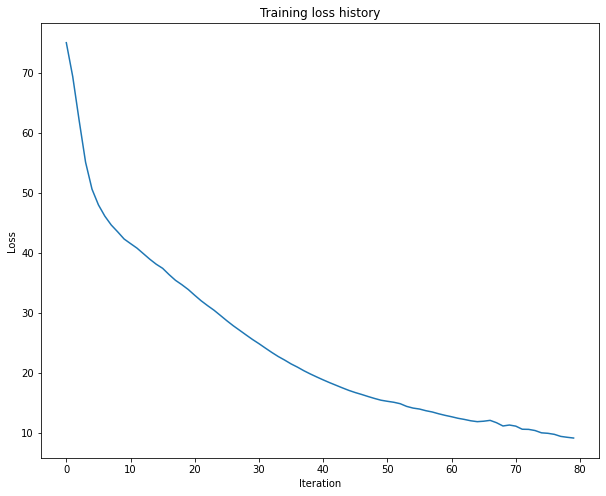

In [33]:
reset_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  attn_overfit, _ = captioning_train(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling
Modify the `CaptioningRNN.sample` method to handle the case where `self.cell_type` is `attention`. **This should take fewer than 10 lines of code.**

When you are done run the following to train a captioning model and sample from the model on some training and validation set samples.

### Train the net
Now, perform the training on the entire training set. You should see a final loss less than `1.0`. Each epoch should take ~8s to run.

learning rate is:  0.001
(Epoch 0 / 60) loss: 50.5033 time per epoch: 6.3s
(Epoch 1 / 60) loss: 48.9156 time per epoch: 6.3s
(Epoch 2 / 60) loss: 47.2104 time per epoch: 6.3s
(Epoch 3 / 60) loss: 44.3746 time per epoch: 6.3s
(Epoch 4 / 60) loss: 41.5958 time per epoch: 6.3s
(Epoch 5 / 60) loss: 38.8926 time per epoch: 6.3s
(Epoch 6 / 60) loss: 36.8671 time per epoch: 6.3s
(Epoch 7 / 60) loss: 35.1561 time per epoch: 6.3s
(Epoch 8 / 60) loss: 33.5702 time per epoch: 6.3s
(Epoch 9 / 60) loss: 32.0497 time per epoch: 6.3s
(Epoch 10 / 60) loss: 30.5180 time per epoch: 6.3s
(Epoch 11 / 60) loss: 28.9798 time per epoch: 6.3s
(Epoch 12 / 60) loss: 27.4687 time per epoch: 6.3s
(Epoch 13 / 60) loss: 26.1023 time per epoch: 6.3s
(Epoch 14 / 60) loss: 24.6014 time per epoch: 6.3s
(Epoch 15 / 60) loss: 23.0467 time per epoch: 6.3s
(Epoch 16 / 60) loss: 21.8127 time per epoch: 6.3s
(Epoch 17 / 60) loss: 20.4453 time per epoch: 6.3s
(Epoch 18 / 60) loss: 19.3208 time per epoch: 6.3s
(Epoch 19 / 60) 

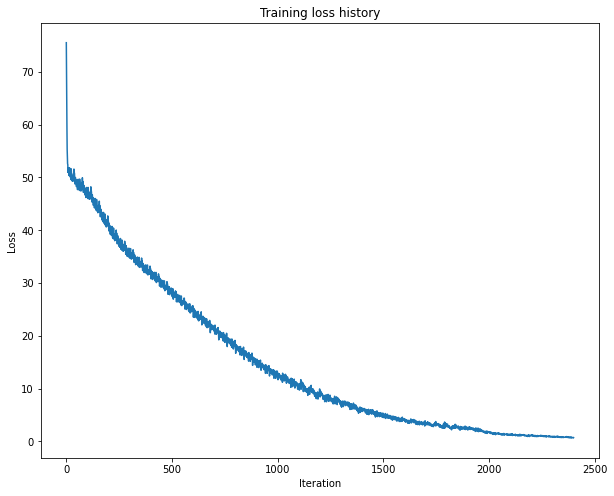

In [34]:
reset_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
attn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  attn_model_submit, attn_loss_submit = captioning_train(attn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling and visualization
As with RNN and LSTM, the samples on training data should be very good; the samples on validation data will probably make less sense.

We use the `attention_visualizer` function from `eecs598/utils.py` to visualize the attended regions per generated word. Note that sometimes the attended regions (brighter) might not make much sense particially due to our low resolution image input. In real applications, the attended regions are more accurate.

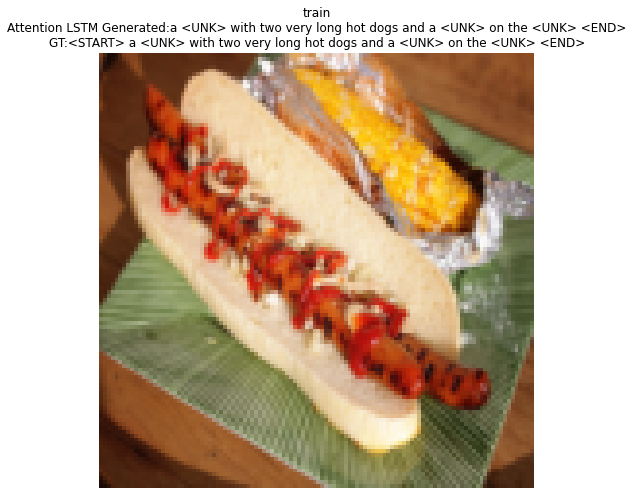

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


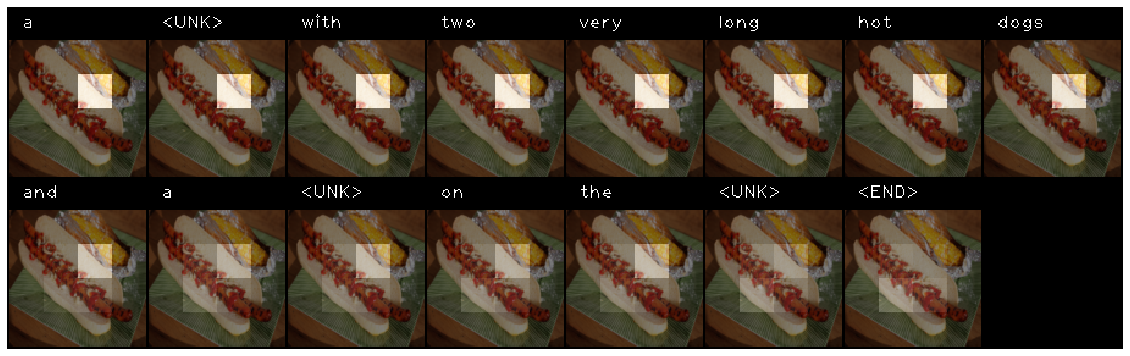

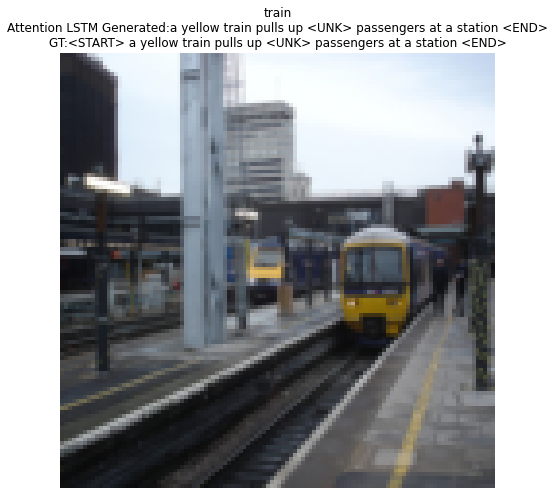

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


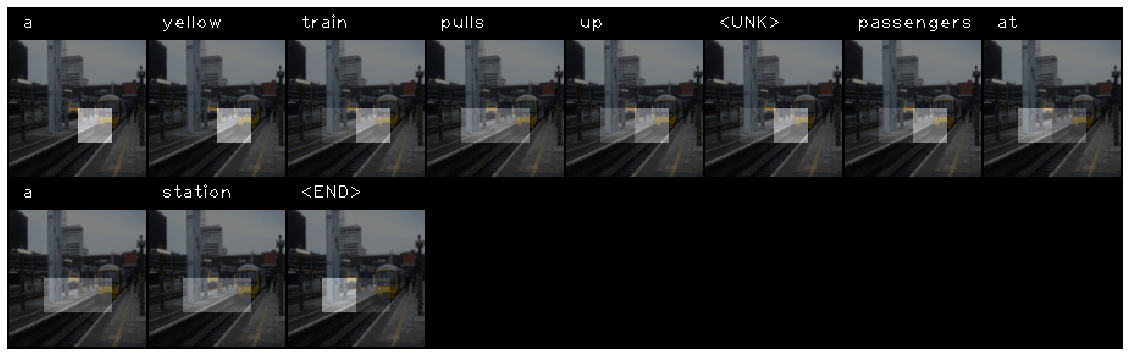

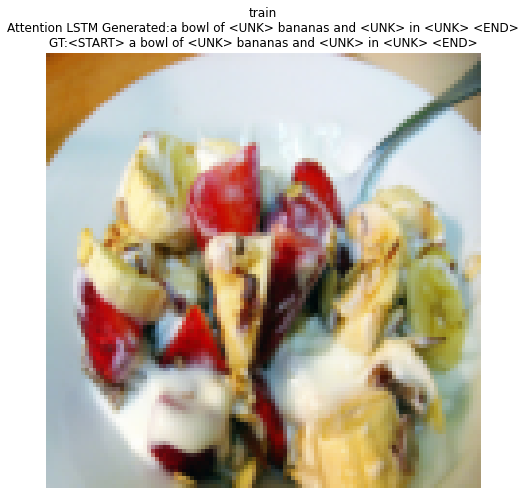

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


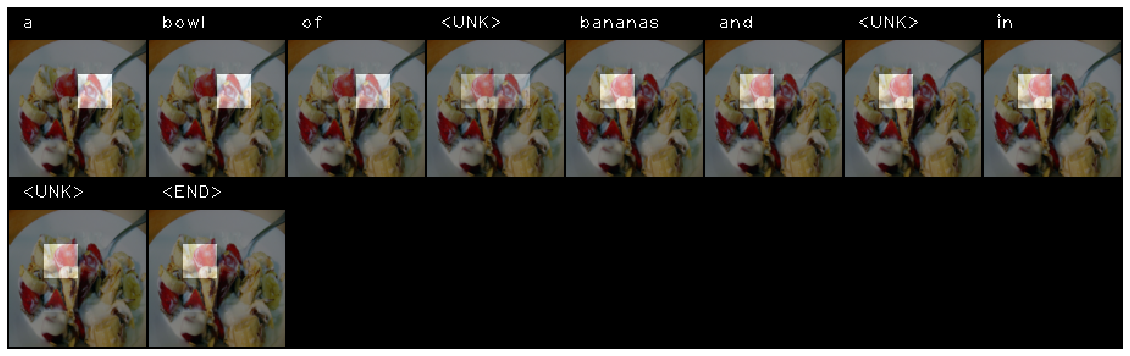

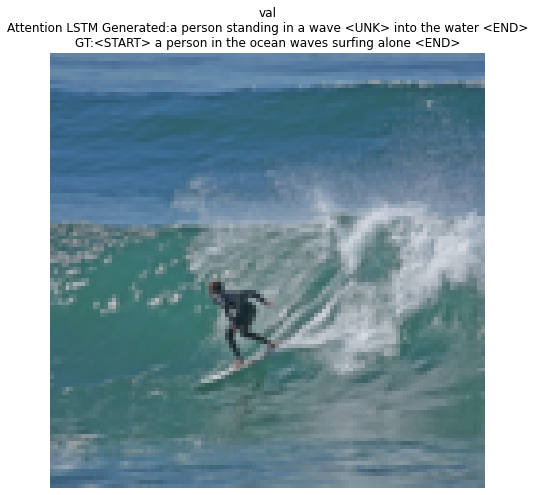

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


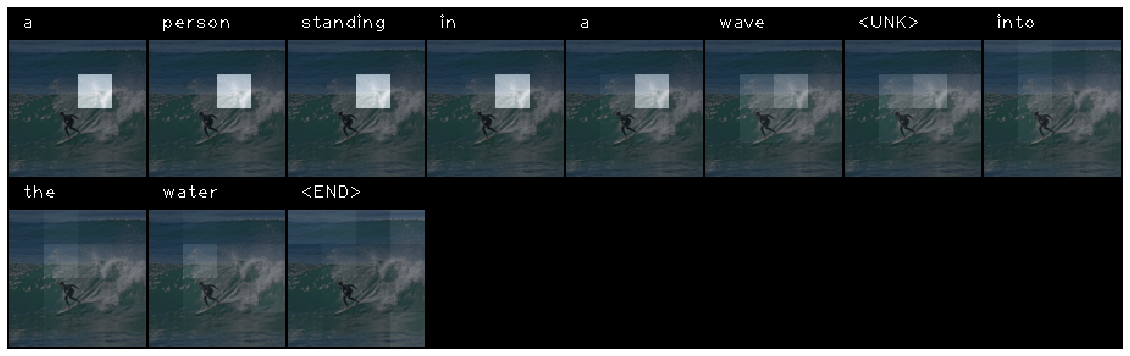

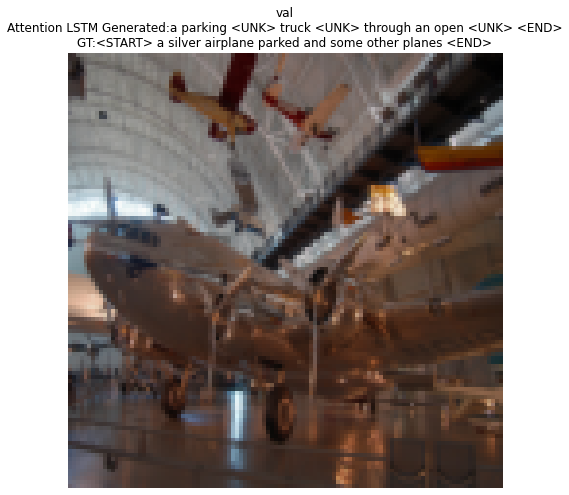

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


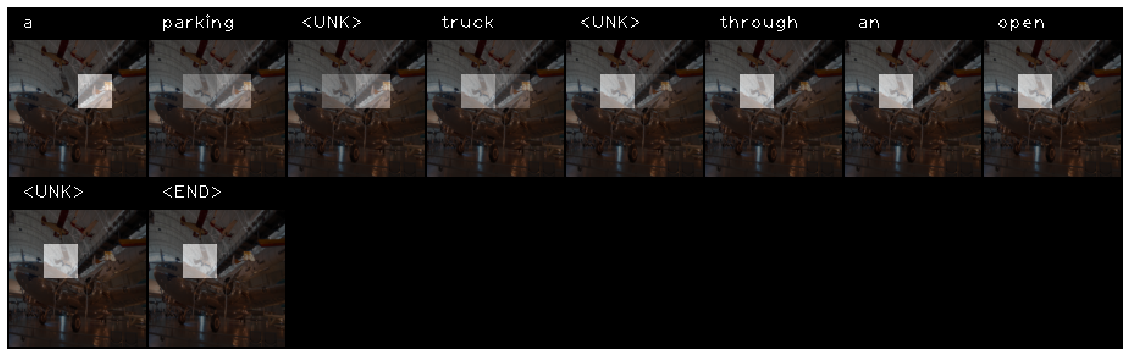

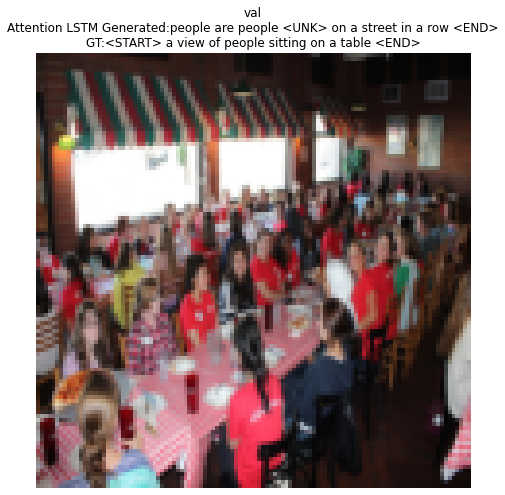

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


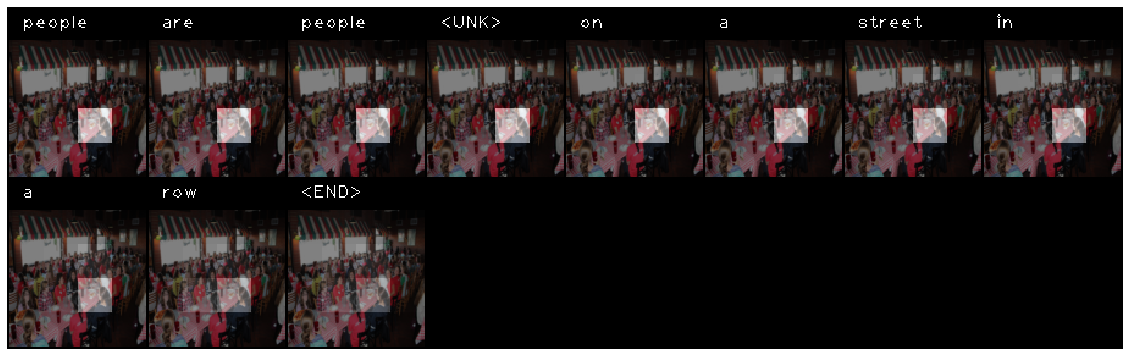

In [35]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.

batch_size = 3
from torchvision.utils import make_grid
from torchvision import transforms

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  attn_model.eval()
  generated_captions, attn_weights_all = attn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nAttention LSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()
    
    tokens = generated_captions[i].split(' ')
    
    vis_attn = []
    for j in range(len(tokens)):
      img = sample_images[i]
      attn_weights = attn_weights_all[i][j]
      token = tokens[j]
      img_copy = attention_visualizer(img, attn_weights, token)
      vis_attn.append(transforms.ToTensor()(img_copy))
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vis_attn = make_grid(vis_attn, nrow=8)
    plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Final checks
Make sure you run "Runtime -> Restart and run all..." to double check the RNN/LSTM code is still functioning well after all the changes you have made!

# Save results

Once all the cells are completed, save the final losses for submission.

In [36]:
submission = {
    'rnn_losses': rnn_loss_submit,
    'lstm_losses':  lstm_loss_submit,
    'attn_losses': attn_loss_submit
}
submission_path = os.path.join(GOOGLE_DRIVE_PATH, 'rnn_lstm_attention_submission.pkl')
dump_results(submission, submission_path)